## Ссылка на статьи: 
1. https://habr.com/ru/articles/207160/
2. Алжеев Андрей Вадимович, Кочкаров Расул Ахматович Сравнительный анализ прогнозных моделей ARIMA и LSTM на примере акций российских компаний // Финансы: теория и практика. 2020. №1. URL: https://cyberleninka.ru/article/n/sravnitelnyy-analiz-prognoznyh-modeley-arima-i-lstm-na-primere-aktsiy-rossiyskih-kompaniy (дата обращения: 27.04.2023).
3. https://analyzingalpha.com/autoregressive-model-python
4. https://analyzingalpha.com/interpret-arima-results
5.https://cyberleninka.ru/article/n/metodika-postroeniya-modeli-arima-dlya-prognozirovaniya-dinamiki-vremennyh-ryadov/viewer

## Для построения модели на своих данных на основе статьи, была выбрна статья под номером 2 и акции компании М.Видео

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_absolute_error, accuracy_score, mean_squared_error
from sklearn import linear_model

Анализ будем проводить на основе акций М.Видео

In [ ]:
path = 'MVID_210101_220101.csv'

In [ ]:
data = pd.read_csv(path,sep=';')
data

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,MVID,D,20210104,0,718.0,727.9,715.1,725.3,138370
1,MVID,D,20210105,0,723.0,727.7,713.8,720.2,171820
2,MVID,D,20210106,0,720.0,722.4,714.8,715.7,65740
3,MVID,D,20210108,0,715.3,721.8,714.4,721.0,78120
4,MVID,D,20210111,0,723.3,726.4,714.0,715.0,199820
...,...,...,...,...,...,...,...,...,...
250,MVID,D,20211224,0,451.5,453.7,446.6,451.1,345860
251,MVID,D,20211227,0,452.0,454.9,449.6,450.0,380038
252,MVID,D,20211228,0,451.3,452.8,435.0,435.5,651938
253,MVID,D,20211229,0,437.0,445.7,435.2,437.0,534294


# График изменения цен, доходности, скользящие, проверка стационарности

In [ ]:
#функция для изображения изменения цен 
def kol_price(date_nach,date_end,ticker):
    file = pd.read_csv(ticker,sep=';')
    df = pd.DataFrame()
    df['DATE'] = file['<DATE>']
    df['CLOSE']= file['<CLOSE>']
    a = (df['DATE']>=date_nach*10000) & (df['DATE']<(date_end+1)*10000)
    return df['CLOSE'][a]


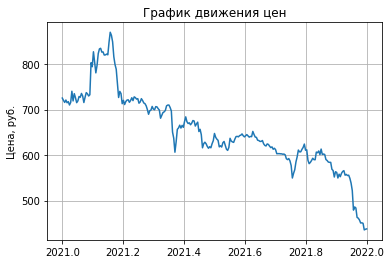

In [ ]:
y = kol_price(2021,2022,path)
x=np.linspace(2021, 2022, len(y))
plt.grid(True)
plt.plot(x, y)
plt.ylabel('Цена, руб.')
plt.title('График движения цен')
plt.show()

Четко прописать даты, когда происходило падение

Рост цены акций в начале года был связан с введением новой дивидентной политики. Основная причина падения акций связана с SPO. Основной владелец М.Видео, группа Сафмар продала 13,5% по 725 рублей в ходе вторичного размещения акций. Во второй половине года акции продолжали падать из-за того, что так как один из владельцев попал в санкционный список ЕС. Также падение можно связать со сножением спроса на сектор ритейлера в целом и переориентацией инвестором на сырьевые истории. Также в целом потребительский сектор был не в фаворитах в условиях роста рублевых процентных ставок.

In [ ]:
#функция для изображения изменения доходности
def doxodn(date_nach,date_end,ticker):
    file = pd.read_csv(ticker,sep=';')
    df = pd.DataFrame()
    df['DATE'] = file['<DATE>']
    df['CLOSE']= file['<CLOSE>']
    df['DOXODN'] = np.zeros((len(file['<CLOSE>']),1))
    for i in range(1,len(df['CLOSE'])):
      df['DOXODN'][i] = (df['CLOSE'][i] - df['CLOSE'][i-1])/df['CLOSE'][i-1]

    a = (df['DATE']>=date_nach*10000) & (df['DATE']<(date_end+1)*10000)
    return df['DOXODN'][a]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


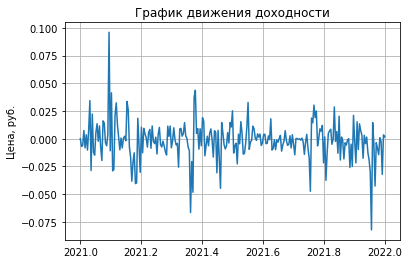

In [ ]:
y = doxodn(2021,2022,path)
x=np.linspace(2021, 2022, len(y))
plt.grid(True)
plt.plot(x, y)
plt.ylabel('Цена, руб.')
plt.title('График движения доходности')
plt.show()

In [ ]:
#скользящая средняя
def skolsredn(date_nach,date_end,ticker):
    file = pd.read_csv(ticker,sep=';')
    df = pd.DataFrame()
    df['DATE'] = file['<DATE>']
    df['CLOSE']= file['<CLOSE>']
    df['SKOLSREDN'] = np.zeros((len(file['<CLOSE>']),1))
    k = 0
    for i in range(4,len(df['CLOSE'])):
      df['SKOLSREDN'][i] = np.mean(df['CLOSE'][k:i+1])
      k+=1

    a = (df['DATE']>=date_nach*10000) & (df['DATE']<(date_end+1)*10000)
    return df['SKOLSREDN'][a]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


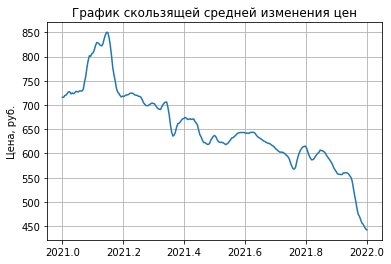

In [ ]:
y = skolsredn(2021,2022,path)[6:]
x=np.linspace(2021, 2022, len(y))
plt.grid(True)
plt.plot(x, y)
plt.ylabel('Цена, руб.')
plt.title('График скользящей средней изменения цен')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


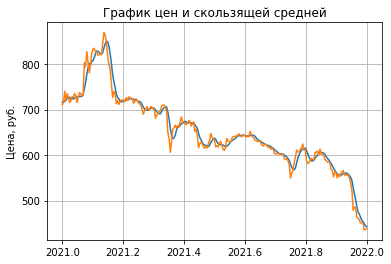

In [ ]:
y_1 = kol_price(2021,2022,path)[6:]

y = skolsredn(2021,2022,path)[6:]
x=np.linspace(2021, 2022, len(y))
plt.grid(True)
plt.plot(x, y, x, y_1)
#plt.plot(x, y)
plt.ylabel('Цена, руб.')
plt.title('График цен и скользящей средней')
plt.show()

In [ ]:
#функция для изображения сглаживания доходности
def skolsredn_dox(date_nach,date_end,ticker):
    file = pd.read_csv(ticker,sep=';')
    df = pd.DataFrame()
    df['DATE'] = file['<DATE>']
    df['CLOSE']= file['<CLOSE>']
    df['DOXODN'] = np.zeros((len(file['<CLOSE>']),1))
    df['SKOLSREDN'] = np.zeros((len(file['<CLOSE>']),1))

    for i in range(1,len(df['CLOSE'])):
      df['DOXODN'][i] = (df['CLOSE'][i] - df['CLOSE'][i-1])/df['CLOSE'][i-1]
    k=0
    for i in range(8,len(df['DOXODN'])):
      df['SKOLSREDN'][i] = np.mean(df['DOXODN'][k:i+1])
      k+=1

    a = (df['DATE']>=date_nach*10000) & (df['DATE']<(date_end+1)*10000)
    return df['SKOLSREDN'][a]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


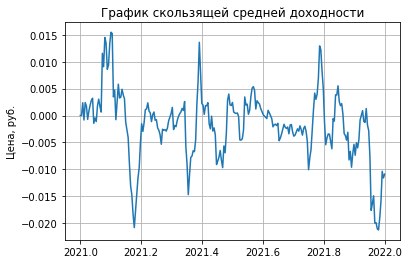

In [ ]:
y = skolsredn_dox(2021,2022,path)[6:]
x=np.linspace(2021, 2022, len(y))
plt.grid(True)
plt.plot(x, y)
plt.ylabel('Цена, руб.')
plt.title('График скользящей средней доходности')
plt.show()

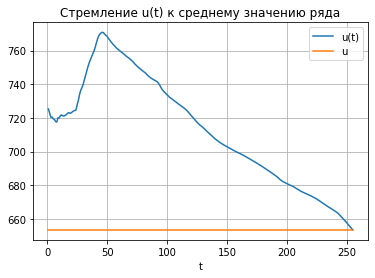

In [ ]:
x = np.arange(1,data['<CLOSE>'].shape[0]+1)
y = np.around(np.cumsum(data['<CLOSE>'].values) / np.arange(1,data['<CLOSE>'].shape[0]+1),4) 
plt.plot(x,y,label = 'u(t)')
plt.plot(x,[np.mean(data['<CLOSE>'].values)]*len(x),label = 'u')
plt.grid()
plt.xlabel('t')

plt.title('Стремление u(t) к среднему значению ряда') 
plt.legend()

Видим, что с увеличением выборки среднее только стремится к постоянной величине, но не является постоянным

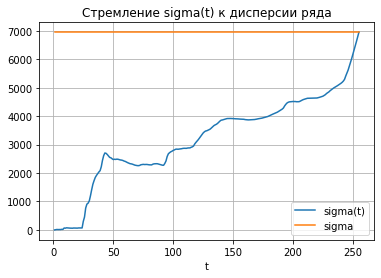

In [ ]:
x = np.arange(1,data['<CLOSE>'].shape[0]+1)
y = np.cumsum(data['<CLOSE>'].values**2)/x - (np.cumsum(data['<CLOSE>'].values)/x)**2
plt.plot(x,y,label = 'sigma(t)')
plt.plot(x,[np.var(data['<CLOSE>'].values)]*len(x),label = 'sigma') 
plt.grid()
plt.xlabel('t')
plt.title('Стремление sigma(t) к дисперсии ряда')
plt.legend()

Дисперсия также не является постоянной с увеличением выборки

In [ ]:
data['doxodn'] = data['<CLOSE>'].pct_change().fillna(0)

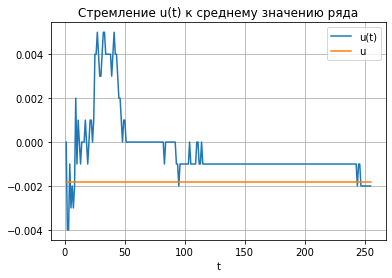

In [ ]:
x = np.arange(1,data['doxodn'].shape[0]+1)
y = np.around(np.cumsum(data['doxodn'].values) / np.arange(1,data['doxodn'].shape[0]+1),3)
plt.plot(x,y,label = 'u(t)') 
plt.plot(x,[np.mean(data['doxodn'].values)]*len(x),label = 'u') 
plt.grid()
plt.xlabel('t')
plt.title('Стремление u(t) к среднему значению ряда') 
plt.legend()

Среднее с увеличением выборки близко к постоянному

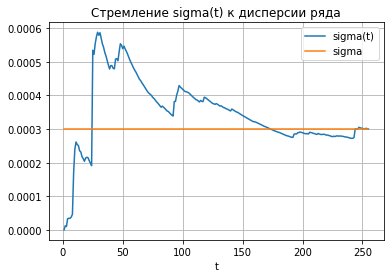

In [ ]:
x = np.arange(1,data['doxodn'].shape[0]+1)
y = np.cumsum(data['doxodn'].values**2)/x - (np.cumsum(data['doxodn'].values)/x)**2
plt.plot(x,y,label = 'sigma(t)') 
plt.plot(x,[np.var(data['doxodn'].values)]*len(x),label = 'sigma') 
plt.grid()
plt.xlabel('t')
plt.title('Стремление sigma(t) к дисперсии ряда')
plt.legend()

Дисперсия с увеличением выборки близка к постоянной

In [ ]:
#белый шум
def white_shym(date_nach,date_end,ticker):
    file = pd.read_csv(ticker,sep=';')
    df = pd.DataFrame()
    df['DATE'] = file['<DATE>']
    df['CLOSE']= file['<CLOSE>']
    df['SKOLSREDN'] = np.zeros((len(file['<CLOSE>']),1))
    k = 0
    for i in range(4,len(df['CLOSE'])):
      df['SKOLSREDN'][i] = np.mean(df['CLOSE'][k:i+1])
      k+=1
    
    df['SHYM']= file['<CLOSE>'] - df['SKOLSREDN']  
    a = (df['DATE']>=date_nach*10000) & (df['DATE']<(date_end+1)*10000)
    return df['SHYM'][a]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


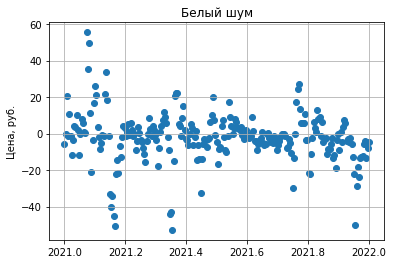

In [ ]:
y = white_shym(2021,2022,path)[6:]
x=np.linspace(2021, 2022, len(y))
plt.grid(True)
plt.scatter(x, y)
plt.ylabel('Цена, руб.')
plt.title('Белый шум')
plt.show()

# Автокорреляционные и автоковариационные функции

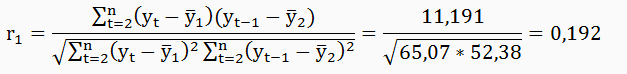

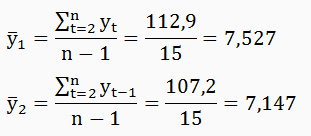

In [ ]:
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


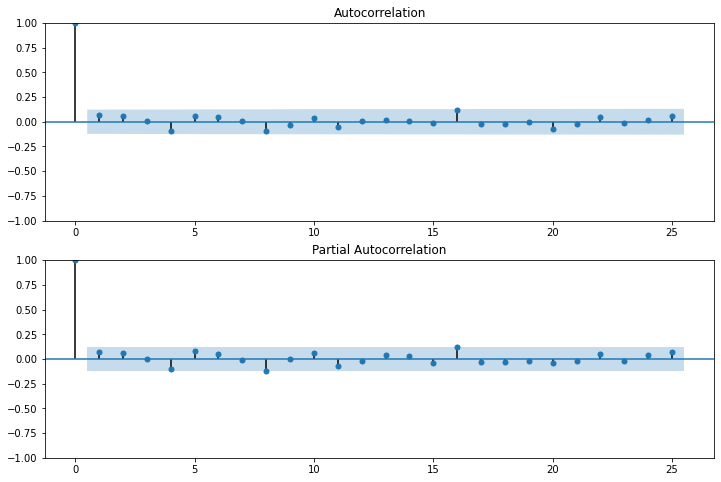

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data['doxodn'], lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data['doxodn'], ax=ax2)

In [ ]:
import statsmodels.api as sm
lags = data['<CLOSE>'].shape[0]-1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  after removing the cwd from sys.path.


[Text(0.5, 0, 'lags(day)'), Text(0.5, 1.0, 'autocorrelation function')]

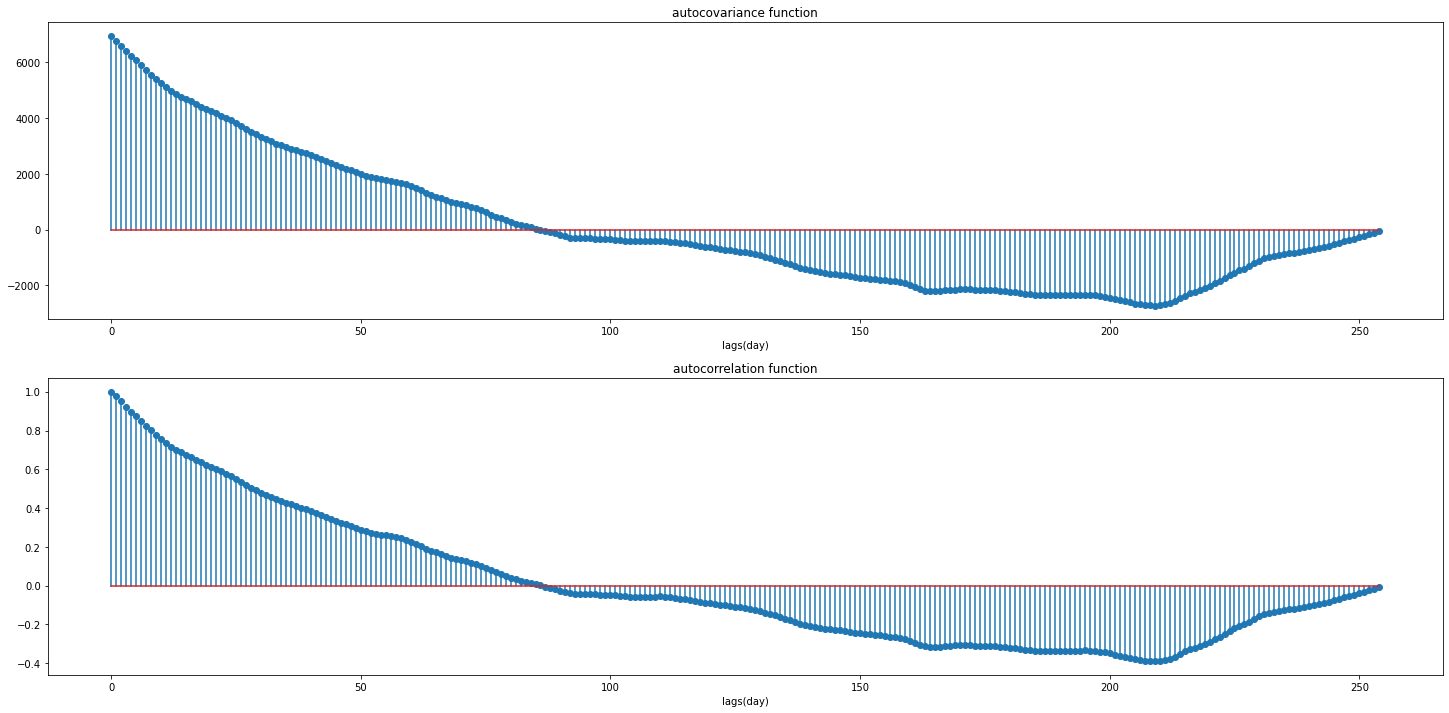

In [ ]:
x = np.arange(lags+1)
fig, axs = plt.subplots(2, 1, figsize=(25, 12)) 
axs[0].stem(x,sm.tsa.stattools.acovf(data['<CLOSE>'],fft = True,nlag=lags)) 
axs[1].stem(x,sm.tsa.stattools.acf(data['<CLOSE>'],fft = True,nlags=lags)) 
axs[0].set(title = 'autocovariance function',xlabel = 'lags(day)')
axs[1].set(title = 'autocorrelation function',xlabel = 'lags(day)')

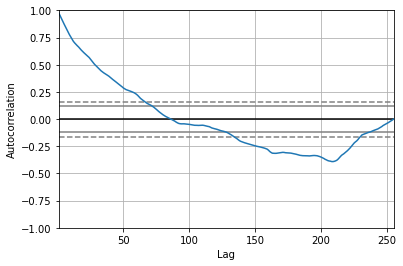

In [ ]:
pd.plotting.autocorrelation_plot(data['<CLOSE>']) #с доверительным интервалом

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  after removing the cwd from sys.path.


[Text(0.5, 0, 'lags(day)'), Text(0.5, 1.0, 'autocorrelation function')]

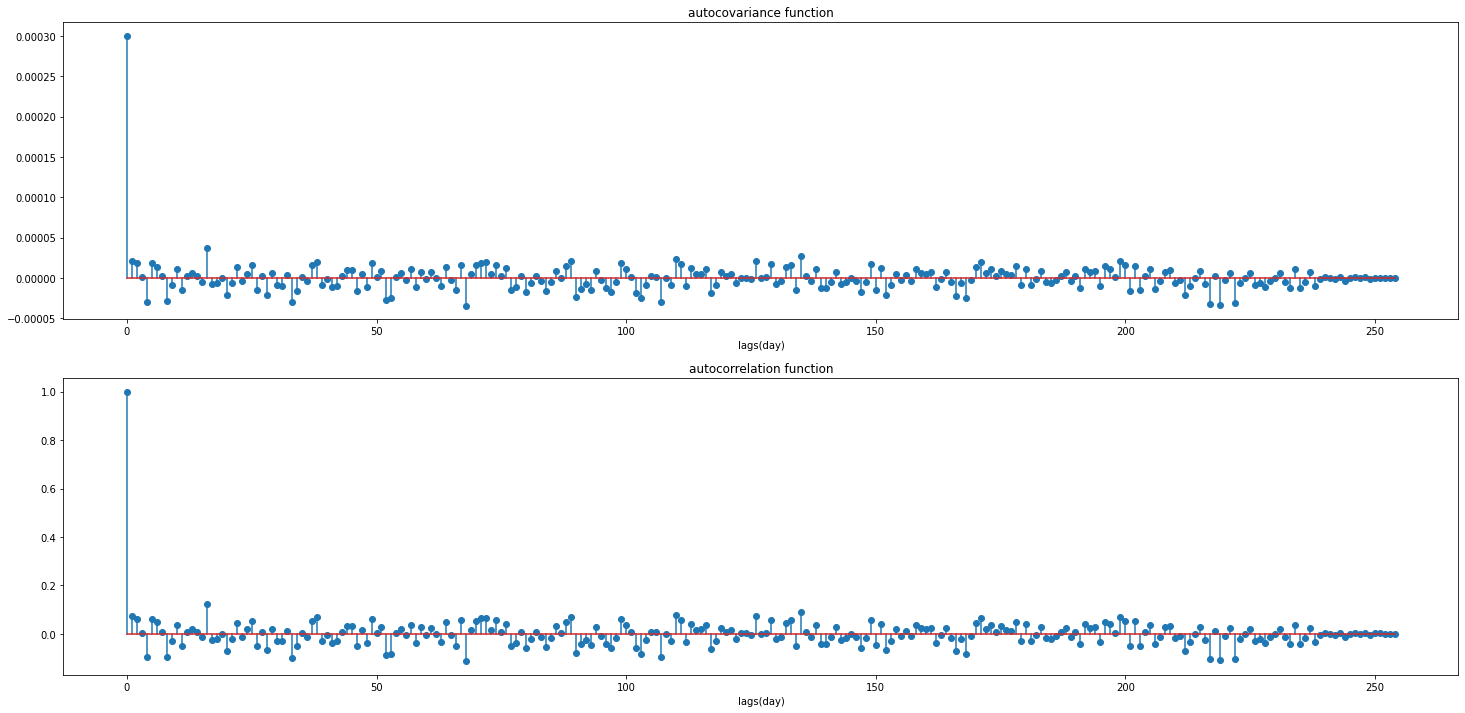

In [ ]:
x = np.arange(lags+1)
fig, axs = plt.subplots(2, 1, figsize=(25, 12)) 
axs[0].stem(x,sm.tsa.stattools.acovf(data['doxodn'],fft = True,nlag=lags)) 
axs[1].stem(x,sm.tsa.stattools.acf(data['doxodn'],fft = True,nlags=lags)) 
axs[0].set(title = 'autocovariance function',xlabel = 'lags(day)')
axs[1].set(title = 'autocorrelation function',xlabel = 'lags(day)')

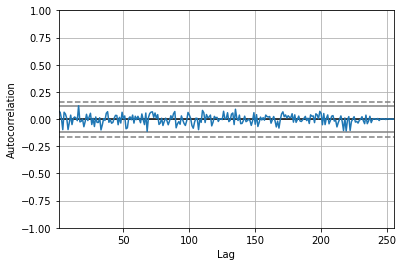

In [ ]:
pd.plotting.autocorrelation_plot(data['doxodn']) #с доверительным интервалом

наши значения от лагов достаточно близки к 0, что говорит нам об независимости автокорреляционной функции от лага

In [ ]:
#функция для вычисления значения функции автокорреляции
def get_auto_corr(timeSeries,k):

    l = len(timeSeries)
 
    timeSeries1 = timeSeries[0:l-k]
    timeSeries2 = timeSeries[k:]
    timeSeries_mean = timeSeries.mean()
    timeSeries_var = np.array([i**2 for i in timeSeries-timeSeries_mean]).sum()
    auto_corr = 0
    for i in range(l-k):
        temp = (timeSeries1[i]-timeSeries_mean)*(timeSeries2[i]-timeSeries_mean)/timeSeries_var
        auto_corr = auto_corr + temp  
    return auto_corr


In [ ]:
ts = np.array(data['<CLOSE>'])
get_auto_corr(ts, 1)

0.9756561630167376

In [ ]:
#функция для изображения значений функции автокорреляции
def plot_auto_corr(timeSeries,k):
    
    timeSeriestimeSeries = pd.DataFrame(range(k))
    for i in range(1,k+1):
        timeSeriestimeSeries.loc[i-1] =get_auto_corr(timeSeries,i)
    plt.bar(range(1,len(timeSeriestimeSeries)+1),timeSeriestimeSeries[0])

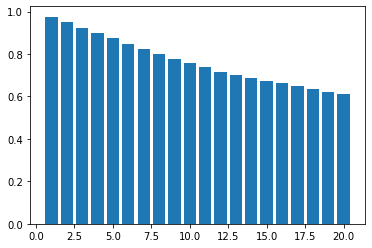

In [ ]:
plot_auto_corr(ts, 20)

По автокорреляционной функции можно сделать вывод, что с увеличением лага степень связи между значениями уменьшается. Также видим, что при h=1, между значениями сильная корреляционная связь. Ряд не содержит циклической компоненты, так как максимум коэффициента корреляции достигается при k = 1. Но из этого можно сделать вывод, что ряд содержит тренд и в нём не присутствует случайная составляющая

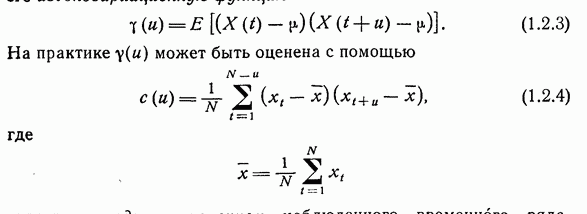

In [ ]:
#функция для вычисления значения автоковариационной функции
def get_auto_covr(timeSeries,k):

    l = len(timeSeries)
 
    timeSeries1 = timeSeries[0:l-k]
    timeSeries2 = timeSeries[k:]
    timeSeries_mean = timeSeries.mean()
    
    auto_covr = []
    for i in range(l-k):
        temp = (timeSeries1[i]-timeSeries_mean)*(timeSeries2[i]-timeSeries_mean)
        auto_covr.append(temp)
    return np.mean(auto_covr)


In [ ]:
ts = np.array(data['<CLOSE>'])
get_auto_covr(ts, 1)

6809.58297639975

In [ ]:
#функция для избражения значений автоковариационной функции
def plot_auto_covr(timeSeries,k):
   
    timeSeriestimeSeries = pd.DataFrame(range(k))
    for i in range(1,k+1):
        timeSeriestimeSeries.loc[i-1] =get_auto_covr(timeSeries,i)
    plt.bar(range(1,len(timeSeriestimeSeries)+1),timeSeriestimeSeries[0])

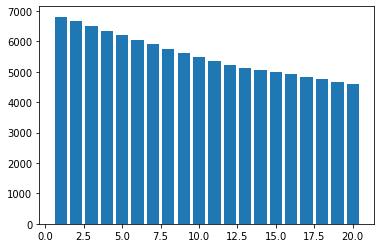

In [ ]:
plot_auto_covr(ts, 20)

По автоковариационной функции можно сделать вывод, что с увеличением лага статистическая зависимость между значениями врменного ряда уменьшается

In [ ]:
#выборочная автоковариационная функция
def get_auto_covr_2(timeSeries,k):

    l = len(timeSeries)

    timeSeries1 = timeSeries[0:l-k]
    timeSeries2 = timeSeries[k:]
    timeSeries_mean = timeSeries.mean()
   
    auto_covr = 0
    for i in range(l-k):
        temp = (timeSeries1[i]-timeSeries_mean)*(timeSeries2[i]-timeSeries_mean)
        auto_covr = auto_covr + temp
    return auto_covr/l


In [ ]:
ts = np.array(data['<CLOSE>'])
get_auto_covr_2(ts, 1)

6782.878729433477

In [ ]:
#функция для избражения значений автоковариационной функции
def plot_vibor_auto_covr(timeSeries,k):
   
    timeSeriestimeSeries = pd.DataFrame(range(k))
    for i in range(1,k+1):
        timeSeriestimeSeries.loc[i-1] = get_auto_covr_2(timeSeries,i)
    plt.bar(range(1,len(timeSeriestimeSeries)+1),timeSeriestimeSeries[0])

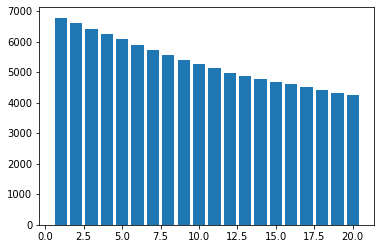

In [ ]:
plot_vibor_auto_covr(ts, 20)

По выборочной автоковариационной функции можно сделать вывод, что с увеличением лага статистическая зависимость между значениями врменного ряда уменьшается

# ARMA

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
from statsmodels.api import OLS

In [ ]:
# рассчитаем доходность 
timeSeries2 = []
for i in range(1,len(data['<CLOSE>'])):
    timeSeries2.append((data['<CLOSE>'][i] - data['<CLOSE>'][i-1])/data['<CLOSE>'][i-1])
timeSeries2

[-0.0070315731421479516,
 -0.006248264371008053,
 0.007405337431884804,
 -0.008321775312066574,
 0.0034965034965034965,
 -0.010313588850174185,
 0.007886213209407158,
 0.03437194355176737,
 -0.028772119411049516,
 0.022253129346314324,
 -0.012244897959183673,
 -0.014876033057851177,
 0.005453020134228156,
 0.013489083576692993,
 -0.0023326015367726837,
 0.011552743776646923,
 -0.007613868116927291,
 -0.0197287299630086,
 0.01607267645003494,
 0.01416781292984863,
 -0.003662010036620008,
 -0.006398039749523612,
 0.003699136868064181,
 0.09609609609609607,
 -0.010958904109588984,
 0.04142533366910095,
 -0.029017047515415305,
 -0.027891918814593422,
 0.021134878954784168,
 0.032363271450075205,
 0.012636695018225974,
 0.0015598752099832832,
 -0.010063495866778592,
 0.0006051071039574005,
 -0.008345428156748885,
 0.0003658982802781659,
 0.0021945866861740482,
 -0.0019464720194647478,
 0.033642125792296466,
 0.025943396226415096,
 -0.007816091954022936,
 -0.01668211306765534,
 -0.0384071630

In [ ]:
#!pip install statsmodels --upgrade

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
from statsmodels.api import OLS

In [ ]:
#AR(1)
def AR_1(date_nach,date_end,ticker,h):
    file = pd.read_csv(ticker,sep=';')
    df = pd.DataFrame()
    df['DATE'] = file['<DATE>']
    df['CLOSE']= file['<CLOSE>']
    df['DOXODN'] = np.zeros((len(file['<CLOSE>']),1))
    df['SKOLSREDN'] = np.zeros((len(file['<CLOSE>']),1))

    for i in range(1,len(df['CLOSE'])):
      df['DOXODN'][i] = (df['CLOSE'][i] - df['CLOSE'][i-1])/df['CLOSE'][i-1]
    k=0
    for i in range(8,len(df['DOXODN'])):
      df['SKOLSREDN'][i] = np.mean(df['DOXODN'][k:i+1])
      k+=1

    a = (df['DATE']>=date_nach*10000) & (df['DATE']<(date_end+1)*10000)

    Y = np.array(df['DOXODN'][a][h+1:])

    l = len(df['DOXODN'][a])-1

    X_1 = np.array(df['DOXODN'][a][h:l-h+1]).reshape((-1, 1))
   

    X_train, X_test, Y_train, Y_test=train_test_split(X_1,Y,test_size=0.2, random_state=0)

    reg = linear_model.LinearRegression()
    reg.fit(X_train, Y_train)

    pred_test = reg.predict(X_test)
    ostatki = Y_test - pred_test
    print('среднее значение остатков:',ostatki.mean())
    print('сумма остатков:',ostatki.sum())
    

    print('MSE:', mean_squared_error(Y, reg.predict(X_1)))
    
    fig, axs = plt.subplots()
    n_bins = len(ostatki)
    axs.hist(ostatki, bins=n_bins)
  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


среднее значение остатков: 0.001142310556585173
сумма остатков: 0.05825783838584382
MSE: 0.0003017107217511398


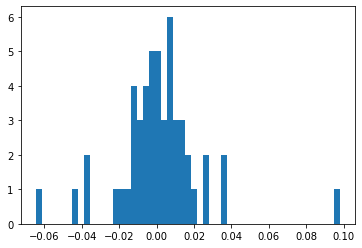

In [ ]:
AR_1(2021,2022,path,1)

In [ ]:
#AR(2)
def AR_2(date_nach,date_end,ticker,h):
    file = pd.read_csv(ticker,sep=';')
    df = pd.DataFrame()
    df['DATE'] = file['<DATE>']
    df['CLOSE']= file['<CLOSE>']
    df['DOXODN'] = np.zeros((len(file['<CLOSE>']),1))
    df['SKOLSREDN'] = np.zeros((len(file['<CLOSE>']),1))

    for i in range(1,len(df['CLOSE'])):
      df['DOXODN'][i] = (df['CLOSE'][i] - df['CLOSE'][i-1])/df['CLOSE'][i-1]
    k=0
    for i in range(8,len(df['DOXODN'])):
      df['SKOLSREDN'][i] = np.mean(df['DOXODN'][k:i+1])
      k+=1

    a = (df['DATE']>=date_nach*10000) & (df['DATE']<(date_end+1)*10000)

    Y = np.array(df['DOXODN'][a][h+1:])

    l = len(df['DOXODN'][a])-1

    X_1 = np.array(df['DOXODN'][a][h:l]).reshape((-1,1))
    X_2 = np.array(df['DOXODN'][a][h-1:l-h+1]).reshape((-1,1))
    X = np.hstack((X_1, X_2))


    X_train, X_test, Y_train, Y_test=train_test_split(X,Y,test_size=0.2, random_state=0)

    reg = linear_model.LinearRegression()
    reg.fit(X_train, Y_train)

    pred_test = reg.predict(X_test)
    ostatki = Y_test - pred_test
    print('среднее значение остатков:',ostatki.mean())
    print('сумма остатков:',ostatki.sum())
    print('MSE:', mean_squared_error(Y, reg.predict(X)))
    fig, axs = plt.subplots()
    n_bins = len(ostatki)
    axs.hist(ostatki, bins=n_bins)
  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


среднее значение остатков: -0.0013107982692813502
сумма остатков: -0.06685071173334886
MSE: 0.00030192144267622437


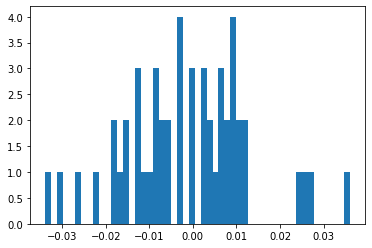

In [ ]:
AR_2(2021,2022,path,2)

Вывод: в модели AR(1) распределение остатков ближе к нормальному по сравнению с AR(2). Также в AR(1) меньше значение мат. ожидания и суммы остатков, чем в AR(2). 

In [ ]:
!pip install statsmodels --upgrade

In [ ]:
from statsmodels.tsa.ar_model import AutoReg

In [ ]:
AR1 = AutoReg(timeSeries2, lags=1).fit()
print(AR1.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  254
Model:                     AutoReg(1)   Log Likelihood                 666.802
Method:               Conditional MLE   S.D. of innovations              0.017
Date:                Thu, 12 May 2022   AIC                          -1327.605
Time:                        06:39:03   BIC                          -1317.005
Sample:                             1   HQIC                         -1323.340
                                  254                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.001     -1.534      0.125      -0.004       0.000
y.L1           0.0720      0.063      1.149      0.251      -0.051       0.195
                                    Roots           

Модель:

$X_t = -0.0017 - 0.072 ⋅ X_{t-1} + u_t$

In [ ]:
from scipy.stats import t

In [ ]:
AR2 = AutoReg(timeSeries2, lags=2).fit()
print(AR2.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  254
Model:                     AutoReg(2)   Log Likelihood                 664.126
Method:               Conditional MLE   S.D. of innovations              0.017
Date:                Thu, 12 May 2022   AIC                          -1320.252
Time:                        06:39:03   BIC                          -1306.135
Sample:                             2   HQIC                         -1314.572
                                  254                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0016      0.001     -1.417      0.157      -0.004       0.001
y.L1           0.0676      0.063      1.075      0.283      -0.056       0.191
y.L2           0.0584      0.063      0.929      0.3

Модель:


$X_t = -0.0016 + 0.0676  ⋅ X_{t-1} + 0.0584  ⋅ X_{t-2} + u_t$

Сравним модели, при помощи информационных критериев Акаике, Шварца и Ханнана-Куина 

AIC1 = -1327.605 < AIC2 = -1320.252 

BIC1 = -1317.005 < BIC2 = -1306.135 

HQIC1 = -1323.340 < HQIC2 = -1314.572

Таким образом, получили, что модель AR1 лучше и следует выбрать ее

In [ ]:
#MA(1) 
def MA_1(date_nach,date_end,ticker,h,sgl = 4):
    file = pd.read_csv(ticker,sep=';')
    df = pd.DataFrame()
    df['DATE'] = file['<DATE>']
    df['CLOSE']= file['<CLOSE>']
    df['DOXODN'] = np.zeros((len(file['<CLOSE>']),1))
    df['SKOLSREDN'] = np.zeros((len(file['<CLOSE>']),1))
    df['SHYM'] = np.zeros((len(file['<CLOSE>']),1))

    for i in range(1,len(df['CLOSE'])):
      df['DOXODN'][i] = (df['CLOSE'][i] - df['CLOSE'][i-1])/df['CLOSE'][i-1]
    k=1
    for i in range(sgl+1,len(df['DOXODN'])):
      df['SKOLSREDN'][i] = np.mean(df['DOXODN'][k:i+1])
      k+=1
    
    for i in range(sgl+1,len(df['DOXODN'])):
      df['SHYM'][i] = df['DOXODN'][i] - df['SKOLSREDN'][i]


    a = (df['DATE']>=date_nach*10000) & (df['DATE']<(date_end+1)*10000)

    Y = np.array(df['DOXODN'][a][h+sgl+1:])
  

    l = len(df['SHYM'][a]) - sgl

    U_1 = np.array(df['SHYM'][a][h+sgl:l-h+sgl]).reshape((-1, 1))


    X_train, X_test, Y_train, Y_test=train_test_split(U_1,Y,test_size=0.2, random_state=0)

    reg = linear_model.LinearRegression()
    reg.fit(X_train, Y_train)


    pred_test = reg.predict(X_test)
    ostatki = Y_test - pred_test
    print('среднее значение остатков:',ostatki.mean())
    print('сумма остатков:',ostatki.sum())
    print('MSE:', mean_squared_error(Y, reg.predict(U_1)))
    fig, axs = plt.subplots()
    n_bins = len(ostatki)
    axs.hist(ostatki, bins=n_bins)
  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


среднее значение остатков: -0.0036358055175139815
сумма остатков: -0.18179027587569907
MSE: 0.0003063552755595792


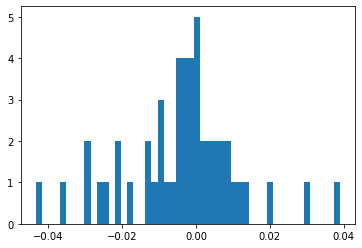

In [ ]:
MA_1(2021,2022,path,1)

In [ ]:
#MA(2)
def MA_2(date_nach,date_end,ticker,h,sgl = 4):
    file = pd.read_csv(ticker,sep=';')
    df = pd.DataFrame()
    df['DATE'] = file['<DATE>']
    df['CLOSE']= file['<CLOSE>']
    df['DOXODN'] = np.zeros((len(file['<CLOSE>']),1))
    df['SKOLSREDN'] = np.zeros((len(file['<CLOSE>']),1))
    df['SHYM'] = np.zeros((len(file['<CLOSE>']),1))

    for i in range(1,len(df['CLOSE'])):
      df['DOXODN'][i] = (df['CLOSE'][i] - df['CLOSE'][i-1])/df['CLOSE'][i-1]
    k=1
    for i in range(sgl+1,len(df['DOXODN'])):
      df['SKOLSREDN'][i] = np.mean(df['DOXODN'][k:i+1])
      k+=1
    
    for i in range(sgl+1,len(df['DOXODN'])):
      df['SHYM'][i] = df['DOXODN'][i] - df['SKOLSREDN'][i]


    a = (df['DATE']>=date_nach*10000) & (df['DATE']<(date_end+1)*10000)


    Y = np.array(df['DOXODN'][a][h+sgl+1:])


    l = len(df['SHYM'][a]) - sgl

    U_1 = np.array(df['SHYM'][a][h+sgl:l-h+1+sgl]).reshape((-1, 1))
    U_2 = np.array(df['SHYM'][a][h+sgl-1:l-h+sgl]).reshape((-1, 1))
    U = np.hstack((U_1, U_2))


    X_train, X_test, Y_train, Y_test=train_test_split(U,Y,test_size=0.2, random_state=0)

    reg = linear_model.LinearRegression()
    reg.fit(X_train, Y_train)


    pred_test = reg.predict(X_test)
    ostatki = Y_test - pred_test
    print('среднее значение остатков:',ostatki.mean())
    print('сумма остатков:',ostatki.sum())
    print('MSE:', mean_squared_error(Y, reg.predict(U)))
    fig, axs = plt.subplots()
    n_bins = len(ostatki)
    axs.hist(ostatki, bins=n_bins)
  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


среднее значение остатков: -0.0004757013896634815
сумма остатков: -0.023785069483174076
MSE: 0.0003058959489519049


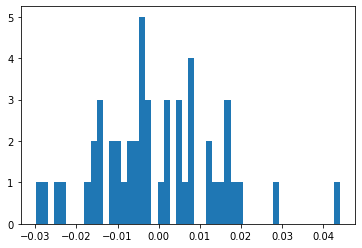

In [ ]:
MA_2(2021,2022,path,2)

Вывод: в модели МА(1) распределение остатков ближе к нормальному по сравнению с МА(2). Также в МА(1) меньше значение мат. ожидания и суммы остатков, чем в МА(2). 

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
MA1 = ARIMA(timeSeries2, order=(0,0,1)).fit()
print(MA1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  254
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 669.818
Date:                Thu, 12 May 2022   AIC                          -1333.636
Time:                        06:39:05   BIC                          -1323.024
Sample:                             0   HQIC                         -1329.367
                                - 254                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.001     -1.553      0.120      -0.004       0.000
ma.L1          0.0684      0.053      1.281      0.200      -0.036       0.173
sigma2         0.0003   1.43e-05     21.001      0.0

Модель:

$X_t = -0.0018 -0.0684 ⋅ u_{t-1} + u_t$

In [ ]:
MA2 = ARIMA(timeSeries2, order=(0,0,2)).fit()
print(MA2.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  254
Model:                 ARIMA(0, 0, 2)   Log Likelihood                 670.449
Date:                Thu, 12 May 2022   AIC                          -1332.897
Time:                        06:39:05   BIC                          -1318.748
Sample:                             0   HQIC                         -1327.205
                                - 254                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.001     -1.447      0.148      -0.004       0.001
ma.L1          0.0666      0.054      1.225      0.220      -0.040       0.173
ma.L2          0.0802      0.049      1.652      0.0

Модель:

$X_t = -0.0018 - 0.0666 ⋅ u_{t-1} - 0.0802 ⋅ u_{t-2} + u_t$


Сравним модели при помощи информационных критериев Акаике, Шварца и Ханнана-Куина  

AIC1 = -1333.636 < AIC2 = -1332.897

BIC1 = -1323.024 < BIC2 = -1318.748

HQIC1 =  -1329.367 < HQIC2 = -1327.205 
 
Таким образом получили, что модель MA1 лучше, поэтому предпочтение отдаём ей

In [ ]:
ARMA = ARIMA(timeSeries2, order=(1,0,1)).fit()
print(ARMA.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  254
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 670.076
Date:                Thu, 12 May 2022   AIC                          -1332.151
Time:                        06:42:07   BIC                          -1318.002
Sample:                             0   HQIC                         -1326.459
                                - 254                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.001     -1.424      0.154      -0.004       0.001
ar.L1          0.5279      0.457      1.156      0.247      -0.367       1.423
ma.L1         -0.4596      0.484     -0.949      0.3

Модель:

$X_t = -0.0018 -0.5279 ⋅X_{t-1} -0.4596 ⋅ u_{t-1} + u_t$